# Data loading and preprocessing

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import rcParams

from fourinarowfunctions import *

datadir = "../data/"
age = pd.read_csv(datadir + "SubjectAge.csv")
pwm = [
    pd.read_csv(datadir + "params_with_metrics_1st_half.csv"),
    pd.read_csv(datadir + "params_with_metrics_2nd_half.csv")
]
bf = [
    pd.read_csv(datadir + "branching_factors_1st_half_full_id.csv").rename(columns={'StudyID': 'subject'}),
    pd.read_csv(datadir + "branching_factors_1st_half_full_id.csv").rename(columns={'StudyID': 'subject'})
]

In [2]:
filename = datadir + 'trialdata.csv'
data_dict = load_data(filename, False)
parsed_dict = {}
for username, data in data_dict.items():
    try:
        parsed_dict[username] = get_parsed_data(data, username, False)
    except AssertionError as e:
        continue
usernames = parsed_dict.keys()
print(f"{len(usernames)} users with complete data")
username2studyid = {username: username.split(":")[0] for username in usernames}
username2psiturkid = {username: username.split(":")[1] for username in usernames}

user 187:R_3oHOHstFKN4HiLA started 34 games.
user 250:R_r2BwOdT2hnmQ5WN started 34 games.
user A242:R_ymscU32j53VKwil started 70 games.
user A1157:R_0GqMhnxN1UuSyZP started 34 games.
user 883:R_b255PQj1bstkMjD started 34 games.
159 users with complete data


In [3]:
#create age bins and dataframes

bins = [7, 12, 17, 25]
ageBinrNr2Value = {0: 10, 1: 15, 2:21}
age['ageBin'] = pd.cut(age['FlooredAge'], bins)
age['ageBinNr'] = age['ageBin'].cat.codes
age['ageBinValue'] = age.apply(lambda row: ageBinrNr2Value.get(row['ageBinNr'], 0), axis = 1)
metrics = []
for i in range(len(pwm)):
    raw_metrics = pwm[i].loc[:,("subject", "fold", "planning depth", "feature drop rate", "heuristic quality", "elo")]
    raw_metrics["StudyID"] = raw_metrics["subject"].apply(lambda x: username2studyid[x])
    raw_metrics = pd.merge(raw_metrics, age, on="StudyID", how="left")
    filtered = raw_metrics.dropna(subset=['ExactAge'])

    dropped_nans = raw_metrics[~raw_metrics.index.isin(filtered.index)]
    print(f"Dropped rows with nans: {len(dropped_nans)}")
    dropped_nans
    #subject A1153 is 27 years old so is excluded.
    
    #drop the double subject
    filtered = filtered[~filtered.subject.str.contains("R_1gV06gSb8WYiLyG")]
    # drop the subject with extremely low elo
    filtered = filtered[~filtered.subject.str.contains("R_24qFUPTZKx0SybQ")]

    col = "AvgBranchingFactor"
    #col = "MedianBranchingFactor"
    metrics.append(pd.merge(filtered, bf[i][["subject", col]].rename(columns={col: 'tree width'}), on="subject", how="left"))

Dropped rows with nans: 5
Dropped rows with nans: 5


In [4]:
metrics[0].head()

,subject,fold,planning depth,feature drop rate,heuristic quality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,ageBinValue,tree width
0,101:R_31SM3mwQvAhBwar,1,7.10208,0.28833,0.390224,125,101,5/19/03,F,17.4904,17.0,11/9/20,"(12, 17]",1.0,15.0,2.947866
1,101:R_31SM3mwQvAhBwar,2,7.01680,0.41846,0.459437,125,101,5/19/03,F,17.4904,17.0,11/9/20,"(12, 17]",1.0,15.0,2.947866
2,101:R_31SM3mwQvAhBwar,3,6.46275,0.34741,0.537905,125,101,5/19/03,F,17.4904,17.0,11/9/20,"(12, 17]",1.0,15.0,2.947866
3,101:R_31SM3mwQvAhBwar,4,6.21521,0.10765,0.316450,125,101,5/19/03,F,17.4904,17.0,11/9/20,"(12, 17]",1.0,15.0,2.947866
4,101:R_31SM3mwQvAhBwar,5,6.64451,0.33834,0.438205,125,101,5/19/03,F,17.4904,17.0,11/9/20,"(12, 17]",1.0,15.0,2.947866


# Plot defintions

In [5]:
age_colors = ['#7DE3AC', '#129951','#20382B']
age_labels = ["8-12","13-17","18-25"]

rcParams['font.family'] = "sans-serif" 
rcParams['font.weight'] = "roman" 
rcParams['font.style'] = "normal" # not 100% sure what this does but it was recommended
rcParams['font.size'] = 32 # not 100% sure what this does but it was recommended
rcParams['pdf.fonttype'] = 42
rcParams['axes.linewidth'] = 2 #thickness of the border
rcParams['xtick.major.width'] = rcParams['axes.linewidth'] # make sure line widths are consistent
rcParams['ytick.major.width'] = rcParams['axes.linewidth']
rcParams['axes.spines.right'] = False #hides right border
rcParams['axes.spines.top'] = False #hides top
rcParams['legend.frameon'] = False #hides box around the legend
rcParams['legend.fontsize'] = 18 #font size in pt
rcParams['axes.labelsize'] = 32 
rcParams['xtick.labelsize'] = 24
rcParams['ytick.labelsize'] = rcParams['xtick.labelsize']
rcParams['lines.linewidth'] = 3
rcParams['xtick.major.size'] = 5
rcParams['lines.markersize'] = 16
rcParams['ytick.major.size'] = rcParams['xtick.major.size']
rcParams['figure.figsize'] = (3.3,3) #figure size in inches

def set_labels(ax, title, reposition_ticks = True, age_categories = True):
    ax.set_xlabel("Age", fontsize = 18)
    ax.set_ylabel(title, fontsize = 18)
    labels = age_labels.copy()
    if reposition_ticks:
        ax.set_xticks(list(ageBinrNr2Value.values()))
    if age_categories:
        ax.set_xticklabels(labels, fontsize = 15)
    ax.tick_params(labelsize=15)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend([])
    return ax

def plot_scatter_metric(col, title, df, ax, age_categories = True):
    size = 250
    age_markers = ['s', '^', 'o']
    for i in range(3):
        df[df["ageBinNr"] == i].plot.scatter("ExactAge", col, c = age_colors[i], ax = ax, s = 60, alpha = 0.7, marker=age_markers[i])
    print(f"{len(df.dropna(subset=[col]))} subjects used in this graph")
    set_labels(ax, title, age_categories, age_categories)

def plot_with_regression(col, title, df, order = 1):
    df = df.groupby("subject").mean().reset_index()
    plt.figure()
    ax = sns.regplot(data = df, x = "ExactAge", y = col, scatter = False, order = order, robust = order == 1, color = 'k')
    plot_scatter_metric(col, title, df, ax, False)
    return ax

In [6]:
col2title = {
    "planning depth": "Tree depth",
    "tree width": "Tree width",
    "heuristic quality": "Heuristic quality",
    "feature drop rate": "Feature drop rate"
}

# Plots for 1st half

156 subjects used in this graph
156 subjects used in this graph
156 subjects used in this graph
156 subjects used in this graph


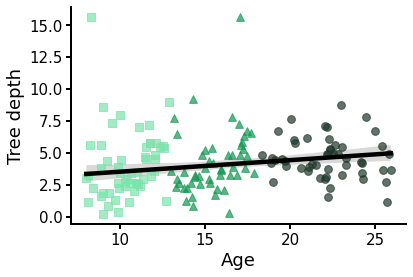

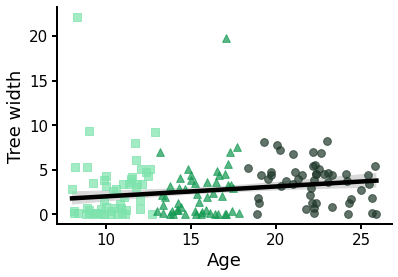

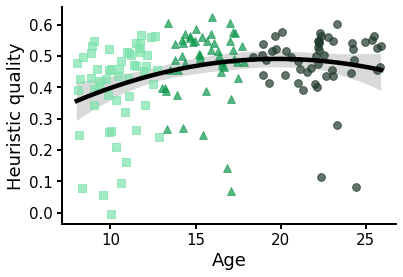

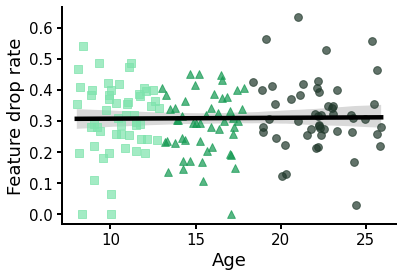

In [7]:
for col, title in col2title.items():
    plot = plot_with_regression(col, title, metrics[0], 2 if col == "heuristic quality" else 1)
    plot.get_figure().savefig(f"../data/reg_plot_scatter_{title.replace(' ', '_')}_1st_half.pdf", dpi=300, bbox_inches='tight')

# Plots for 2nd half

156 subjects used in this graph
156 subjects used in this graph
156 subjects used in this graph
156 subjects used in this graph


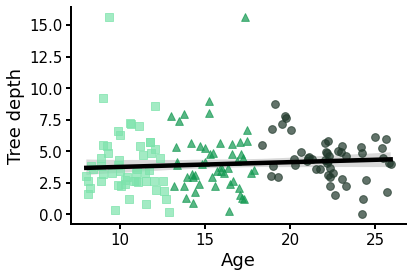

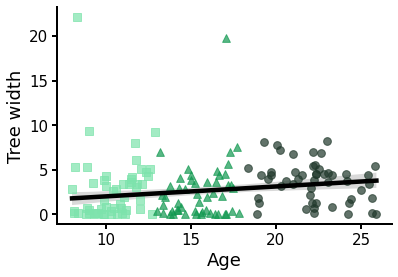

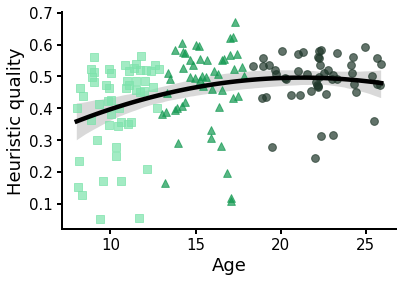

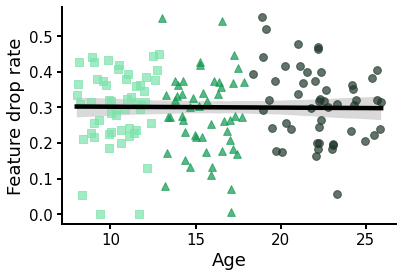

In [8]:
for col, title in col2title.items():
    plot = plot_with_regression(col, title, metrics[1], 2 if col == "heuristic quality" else 1)
    plot.get_figure().savefig(f"../data/reg_plot_scatter_{title.replace(' ', '_')}_2nd_half.pdf", dpi=300, bbox_inches='tight')